820 Capstone Project - Code Submission (Predicting Churn in the Telco Industry)

In [56]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, chi2




# load telco customer churn dataset into pandas datframe
data = pd.read_csv('c:\datasets\churn.csv')

In [57]:
# Print the dimensions of the dataset and the data types of each column

print("Dimensions:", data.shape, "\n")
print("Variable types:")
print(data.info())

# At this point, it appears there are no missing values in the dataset

Dimensions: (7043, 21) 

Variable types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

AxesSubplot(0.125,0.11;0.775x0.77)


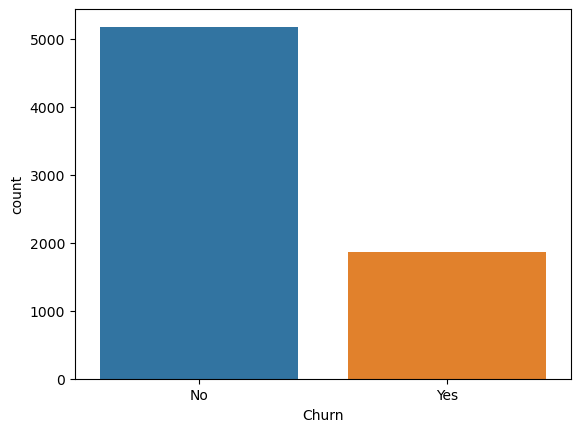

In [59]:
# Visualize distribution of class variable 'Churn'

churn_dist=sns.countplot(x='Churn', data=data)
print(churn_dist)

# From the plot, we can see that approximately 27% of customers have churned

Data Cleaning

In [60]:
# 'TotalCharges' is actually a numerical attriibute (it shows a total amount), but it was read as an object
# (because of presence of strings or spaces).  

#  Convert 'TotalCharges' to a numerical data type

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Check for any missing values in the dataset after the conversion

data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [61]:
# There are 11 rows with missing values in 'TotalCharges'. 

# 'TotalCharges' feature is dropped due to correlation with 'MonthlyCharges' and 'Tenure'. 
# This is done to avoid multicollinearity, which can lead to problems when fitting models
# and interpreting results. Additionally, as 'TotalCharges' is typically calculated 
# as 'MonthlyCharges' times 'Tenure', it's likely a redundant feature that doesn't
# provide new information. Performance metrics ultimately validated this decision.
# (See EDA report: In[8])

data.drop(columns='TotalCharges',inplace=True) 

# Note: EDA showed there are no outliers in the dataset.

Feature Selection

In [63]:
# Feature Selection:

# Because the customerID feature has no value in terms of explaining churn, it is dropped.

data.drop(columns='customerID', inplace=True)


# The columns 'MultipleLines', 'PhoneService', 'StreamingTV', 'StreamingMovies', and 'Gender' 
# were dropped from the dataset. This decision was based on both statistical testing and visual
# inspection of the data. Firstly, these features had low chi-squared scores during the 
# EDA process, suggesting a weaker relationship with the target variable.
# Secondly, upon visualizing the distributions of these features relative to 'Churn', 
# in some cases it was observed that they do not seem to significantly influence churn.
# After testing performance with & without these features, I saw that their absence didnt really change
# the metrics. In some cases, it led to slight improvements, suggesting these
# features might have introduced some noise or unnecessary complexity into the models. 
# Thus I decided to exclude these features from the datset.
# (See end of EDA report for Chi-Square test results)



data.drop(columns='MultipleLines',inplace=True) 
data.drop(columns='PhoneService',inplace=True)
data.drop(columns='StreamingTV',inplace=True)
data.drop(columns='StreamingMovies',inplace=True)
data.drop(columns='gender',inplace=True)


# I also experimented with replacing individual service features with 'TotalServices', a count of the number
# of services. This aimed to capture the service usage and reduce dimensionality. Model performance
# ultimately invalidated this experiment.

Feature Transformation

In [64]:
# Some features have 'No internet service' and 'No phone service' values which
# essentially mean 'No'. They are replaced with 'No' in the relevant columns.

cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

for col in cols:
     data[col] = data[col].replace('No internet service', 'No')


In [65]:

# List the columns that need to be label encoded
label_encode_cols = [ 'Partner', 'Dependents',
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'PaperlessBilling','Churn']

# Label encoding is used for binary features, where each unique category can be represented as 0 or 1.
# This is suitable for binary yes/no features, as it preserves the meaningful 
# contrast between two categories without adding more features.


# Apply the label encoding 
label_encoder = LabelEncoder()
for col in label_encode_cols:
    data[col] = label_encoder.fit_transform(data[col])
    
    
# One-hot encoding is used to convert categorical variables into a numerical representation.
# Each category in a feature will be transformed into a separate binary column, where 
# a value of 1 indicates the presence of that category and 0 indicates its absence.
# This conversion allows us to represent categorical data in a format that can be
# understood and processed by mathematical models.

#  Apply one-hot encoding to categorical features that are not binary
data = pd.get_dummies(data, columns=['InternetService', 'Contract', 'PaymentMethod'])



In [66]:
# Separation of features (X) from target variable (y).

X = data.drop('Churn', axis=1)
y = data['Churn']


# Numerical columns in the dataset-- these will be scaled later to ensure
# model performance isn't negatively impacted by the range of values.

numerical_cols = ['tenure', 'MonthlyCharges']


In [67]:
# 80 20 split ensures that the models get enough data to learn from, and also leaves 
# enough data to evaluate the generalization ability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

******  Modeling & Evaluation  *********

In [68]:
#     **** IMPORTANT ****

# In this section, I'll build, evaluate, & tune predictive models for this project.

# Models:
# 1. Logistic Regression
# 2. Random Forest 
# 3. Decision Tree

# Each model's hyperparameters are systematically explored using GridSearchCV, which identifies the best parameter
# combination based on cross-validation performance. 

# Stratified K-Fold cross-validation is used to ensure that our model's validation results are reliable, 
# given the imbalanced nature of our dataset. Stratification ensures each fold is a fair representation
# of the entire dataset.

# In the cross-validation process, I'm using a pipeline that includes preprocessing steps like scaling
# and resampling. These transformations are fit on and applied only to the training data within
# each fold, preventing data leakage. The learned transformations from scaling, but not resampling,
# are then applied to the validation data. GridSearchCV helps manage this by ensuring these steps
# are properly executed for each training-validation split during cross-validation.

# After all hyperparameter combinations are evaluated and the best one is determined (based on the given scoring
# metric, the Matthews Correlation Coefficient) -- the best model is then refit on the entire training dataset.
# During this refitting process, the pre-processing steps (scaling and resampling) are automatically
# applied to the entire training set. 


# Dataset split:
# 1. Training set: Used for model training and hyperparameters tuning through cross-validation.
# 2. Test set: An unseen data set used to evaluate the final models.

# Resampling methods:
# 1. SMOTE: This technique synthetically generates new examples in the minority class to deal with class imbalance.
# 2. Undersampling: This method reduces the number of examples in the majority class to match the size of the 
#    minority class. 

# Comparisons between the results obtained from SMOTE and undersampling will provide insights into the effects of these
# techniques on model performance.




In [69]:
# Docstring for 'run_models(resampler)' function.
    
#     This function runs a set of predictive models on the Telco customer churn dataset to find 
#     customers at risk of churn. It uses a pipeline to handle preprocessing steps and hyperparameter tuning.
    
#     It follows these steps:
#     
#     1. Uses a set of predefined predictive models (LRegression, RForest & Decision Tree).
#     2. Uses a set of predefined hyperparameters for each model.
#     3. Sets up a preprocessing pipeline that scales numerical features, and 
#        handles resampling.
#     4. Uses StratifiedKFold cross-validation to ensure balanced classes during model tuning.
#     5. For each model, it uses GridSearchCV to find the best hyperparameters, and then refits that model on the whole 
#        training set using the best found hyperparameters. 
#     6. Evaluates each of the best model's performance on the test set and prints the result.
#     7. Finally, it returns the performance metrics for each model.

# (The use of random_state=42 in the next cells is for the purpose of reproducibility.)

In [70]:
# Define dictionaries that will be used by function: run_models(resampler) 


# Declare the models which will be used
models = {  # max_iter is set to 1000 to allow enough iterations for convergence
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
    }
    

# Dictionary of Hyperparameters for each model to be tuned using GridSearchCV. 
# These are common choices for this type of problem. Default paramaters are included as well.
# When using a pipeline with gridsearchcv we need to use '__' format as below.
hyperparameters = { 
        
"Logistic Regression": {'logisticregression__C': [0.1, 1, 10] },       
    # 'C' is the inverse of regularization strength.
    # Smaller values specify stronger regularization, larger values specify weaker regularization.
    # The values [0.1, 1, 10] are specifyed to try different levels of regularization.

"Random Forest": {
    'randomforestclassifier__n_estimators': [10, 50, 100],
    'randomforestclassifier__max_depth': [None, 10, 20, 30]
    # 'n_estimators' is the number of trees in the random forest.
    # 'max_depth' is the maximum depth of each decision tree.
    # The values [10, 50, 100] are used to try different numbers of trees,
    # and the values [None, 10, 20, 30] are used to try different maximum depths.    
            
    },
"Decision Tree": {'decisiontreeclassifier__max_depth': [None, 5]}
    # 'max_depth' specifies the maximum depth of the decision tree.
    # The values [None, 5] are specified to try an unbounded tree (None) and a tree 
    # with maximum depth of 5.
}


# Scoring dictionary is used to instruct GridSearchCV to compute
# these metrics for each combination of hyperparameters during the cross-val process.
# We will then be able to print these metrics and their std's for the best model 
# chosen by GridsearchCV, for each algorithm.

scoring = {
'accuracy': make_scorer(accuracy_score),
'precision': make_scorer(precision_score),
'recall': make_scorer(recall_score),
'f1': make_scorer(f1_score),
'mcc': make_scorer(matthews_corrcoef)
     }

In [84]:

# Modeling/Evaluation

# Define function to run models/evaluations with resampling technique as paramater.


def run_models(resampler):
        
    # Create stratified k-fold cross-validation object. 5 folds is a common choice-- 
    # providing a good balance between efficiency and reliability of estimates.
    
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    best_train_time = {} # dictionary to store avg train time in cross-val for best model for each algo
    best_cross_val_score = {} # dictionary for cross-val scores obtained for best model for each algo
    test_scores = {} # dictionary to store testset scores obtained for the best models
    best_cross_val_std={} # dictionary for std's of cross-val scores for the best models (stability)
    
    global best_estimators
    best_estimators = {} # Dictionary to store the best model found for each algorithm
                         # to be used for feature importance later (global so we can access it)


    print(f"All Results with {resampler}:\n")
    
    # Loop through all models & hyperparameters
    for model_name, model in models.items():
        
        # Create preprocessing pipeline for numerical cols.
        # This will allow proper scaling of train folds and test fold (based on learning from train folds)
        
        numerical_transformer = make_pipeline(StandardScaler())
        
        # Create preprocessor to transform numerical columns while keeping the
        # other columns unchanged. Apply the numerical_transformer to numerical_cols.
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols)
            ], 
            remainder='passthrough'
        )
        
        # Combine the preprocessor, resampler & model into one pipeline
        pipeline = make_pipeline(preprocessor, resampler, model)
        
        
        # Create instance of GRidsearchCV and assign it to clf.
        # We pass in our pipeline, the set of hyperparameters to test, our cross-validation method, 
        # and our refit metric (MCC).
        # GridSearchCV will fit this pipeline on the data for each combination of hyperparameters
        # and evaluate the performance
        # Matthews Cor-Coef accounts for TP's, FP's, TN's & FN's - robust metric
        # Scoring will calculate all the metrics in the scoring dictionary we defined.

        clf = GridSearchCV(pipeline, hyperparameters[model_name], cv=stratified_kfold, scoring=scoring, refit='mcc')
        
        # Fit GridsearchCV object to training data. After cross-validation, best model (highest mcc) will be
        # refit on entire training set
 
        clf.fit(X_train, y_train)

  
        # Save the best model found for each algo (used for feature importance later on)
        best_estimators[model_name] = clf.best_estimator_
  
        # Get the index of the best model (best combo of hparams) found by GridSearchCV
        best_model_idx = clf.best_index_
    
        # Save avg time taken to train best model across all cross-val folds
        best_train_time[model_name] = clf.cv_results_['mean_fit_time'][best_model_idx]
    
        # Save standard deviation of the cross-val scores for best model for each algo.
        # This gives a measure of stability in model performance   
        best_cross_val_std[model_name] = {
        "Precision": clf.cv_results_['std_test_precision'][best_model_idx],
        "Recall": clf.cv_results_['std_test_recall'][best_model_idx],
        "F1 Score": clf.cv_results_['std_test_f1'][best_model_idx],
        "MCC": clf.cv_results_['std_test_mcc'][best_model_idx]
        }
    
    
        # Save cross validation scores for best model.
        # Mean scores of best model across folds 
        best_cross_val_score[model_name] = {
            "Precision": clf.cv_results_['mean_test_precision'][best_model_idx],
            "Recall": clf.cv_results_['mean_test_recall'][best_model_idx],
            "F1 Score": clf.cv_results_['mean_test_f1'][best_model_idx],
            "MatthewsCor": clf.cv_results_['mean_test_mcc'][best_model_idx]
            }
        
   
    # Use best model found to make predictions on the test set (clf.predict will apply best model)         
    # ** Scaling params learned from training will be used to preprocess test data. **
        y_test_pred = clf.predict(X_test) 
        
    # Get the probabilities necessary for computing AUC    
        y_test_proba = clf.predict_proba(X_test)[:, 1]  

      
    # calculate metrics of model on test set
        accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        mcc = matthews_corrcoef(y_test, y_test_pred)
        auc = roc_auc_score(y_test, y_test_proba)
          
        
    # Save the model performance metrics calculated on test set
        test_scores[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": auc,
            "Matthews CC": mcc
            }
        
    # calculate and print confusion matrix for test set
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"Confusion Matrix for {model_name} on Test Set: \n{cm}")

    # Loop through all models and print stored results
    for model_name in models.keys():
        print(f"\nModel: {model_name} ***********")
        print(f"Avg training time for best model (secs): {best_train_time[model_name]:.3f}")
        print(f"Cross-Val Metrics (Avg of metrics accross folds for best chosen model): ")
    
        for metric, score in best_cross_val_score[model_name].items():
            print(f" {metric}: {score:.3f}")
        
        print(f"Standard Deviations for Cross-Val Metrics (stability of best chosen model): ")
        for metric, value in best_cross_val_std[model_name].items():
            print(f" {metric}: {value:.3f}")
        
        print(f"Test Set Accuracy: {test_scores[model_name]['Accuracy']:.3f}")
        print(f"Test Set Precision: {test_scores[model_name]['Precision']:.3f}")
        print(f"Test Set Recall: {test_scores[model_name]['Recall']:.3f}")
        print(f"Test Set F1 Score: {test_scores[model_name]['F1 Score']:.3f}")
        print(f"Test Set ROC AUC: {test_scores[model_name]['ROC AUC']:.3f}")
        print(f"Test Set Matthews CC: {test_scores[model_name]['Matthews CC']:.3f}")
    
    

In [85]:
# Get results with SMOTE oversampling.
# SMOTE creates synthetic examples in the minority class.

# We'll do the same with undersampling in the next cell.
# One method may work better than the other.

run_models(SMOTE(random_state=42))

All Results with SMOTE(random_state=42):

Confusion Matrix for Logistic Regression on Test Set: 
[[757 279]
 [ 60 313]]
Confusion Matrix for Random Forest on Test Set: 
[[806 230]
 [ 86 287]]
Confusion Matrix for Decision Tree on Test Set: 
[[800 236]
 [ 94 279]]

Model: Logistic Regression ***********
Avg training time for best model (secs): 0.054
Cross-Val Metrics (Avg of metrics accross folds for best chosen model): 
 Precision: 0.511
 Recall: 0.773
 F1 Score: 0.616
 MatthewsCor: 0.456
Standard Deviations for Cross-Val Metrics (stability of best chosen model): 
 Precision: 0.017
 Recall: 0.025
 F1 Score: 0.019
 MCC: 0.029
Test Set Accuracy: 0.759
Test Set Precision: 0.529
Test Set Recall: 0.839
Test Set F1 Score: 0.649
Test Set ROC AUC: 0.859
Test Set Matthews CC: 0.509

Model: Random Forest ***********
Avg training time for best model (secs): 0.069
Cross-Val Metrics (Avg of metrics accross folds for best chosen model): 
 Precision: 0.545
 Recall: 0.718
 F1 Score: 0.620
 MatthewsCor

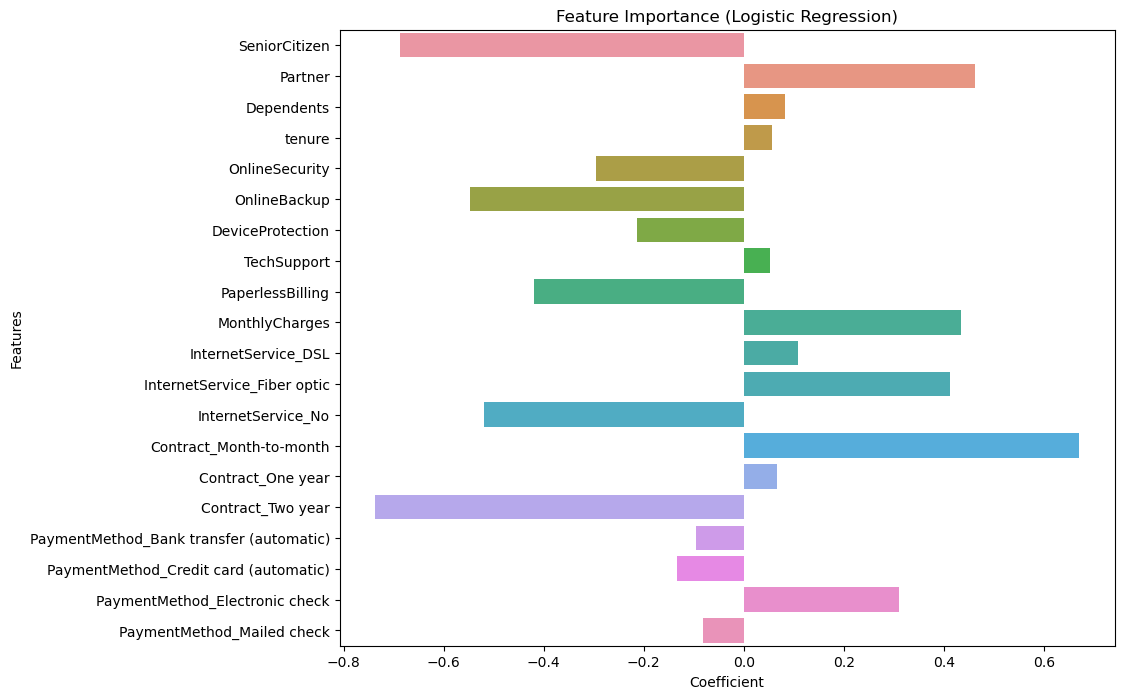

In [86]:
# Feature Importances for Logistic Regression with SMOTE (preliminarily best of 3)

# These are coefficients for best Logistic Regression model (using smote)
# (can be interpreted as the log odds ratio for a one unit increase in the feature)
# Importances for other 2 models can be printed in a similar way.

# load best models which were saved in best_estimators dictionary
logreg_best_model = best_estimators['Logistic Regression'].named_steps['logisticregression'] 

#rf_best_model = best_estimators['Random Forest'].named_steps['randomforestclassifier']
#dtree_best_model = best_estimators['Decision Tree'].named_steps['decisiontreeclassifier']

# Get coefficients
coefficients = logreg_best_model.coef_[0]

# Map the coefficients to feature names
lr_coefs = pd.Series(coefficients, index=X_train.columns)

#print (lr_coefs)

# print barplot
plt.figure(figsize=(10,8))
sns.barplot(y=lr_coefs.index, x=lr_coefs.values)
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.show()


In [87]:
# Get results with undersampling.
# Undersampling reduces the number of samples in the majority class.

run_models(RandomUnderSampler(random_state=42))

All Results with RandomUnderSampler(random_state=42):

Confusion Matrix for Logistic Regression on Test Set: 
[[756 280]
 [ 59 314]]
Confusion Matrix for Random Forest on Test Set: 
[[740 296]
 [ 56 317]]
Confusion Matrix for Decision Tree on Test Set: 
[[693 343]
 [ 59 314]]

Model: Logistic Regression ***********
Avg training time for best model (secs): 0.014
Cross-Val Metrics (Avg of metrics accross folds for best chosen model): 
 Precision: 0.507
 Recall: 0.778
 F1 Score: 0.614
 MatthewsCor: 0.453
Standard Deviations for Cross-Val Metrics (stability of best chosen model): 
 Precision: 0.013
 Recall: 0.030
 F1 Score: 0.018
 MCC: 0.027
Test Set Accuracy: 0.759
Test Set Precision: 0.529
Test Set Recall: 0.842
Test Set F1 Score: 0.649
Test Set ROC AUC: 0.860
Test Set Matthews CC: 0.511

Model: Random Forest ***********
Avg training time for best model (secs): 0.080
Cross-Val Metrics (Avg of metrics accross folds for best chosen model): 
 Precision: 0.502
 Recall: 0.793
 F1 Score: 0.614

In [83]:
# Feature Importances for Random Forest model using RandomUnderSampler 
# (this is shown just as an example -- LogisiticRegression seems like the better model.)

# load best models which were saved in best_estimators dictionary

rf_best_model = best_estimators['Random Forest'].named_steps['randomforestclassifier']

# Get importances
importances = rf_best_model.feature_importances_

# Map the coefficients to feature names
rf_importances = pd.Series(importances, index=X_train.columns)

print(rf_importances.sort_values(ascending=False).head(15))


SeniorCitizen                     0.224077
Partner                           0.166760
Contract_Month-to-month           0.136546
Contract_Two year                 0.082435
InternetService_Fiber optic       0.070066
PaymentMethod_Electronic check    0.049687
MonthlyCharges                    0.027019
OnlineBackup                      0.025866
tenure                            0.024196
PaperlessBilling                  0.023110
Contract_One year                 0.022044
InternetService_No                0.021887
OnlineSecurity                    0.021244
TechSupport                       0.020542
DeviceProtection                  0.019323
dtype: float64


In [19]:
# Brief discussion of preliminary results

# In this churn prediction scenario, recall is usually more important because it measures the
# model's ability to correctly identify the customers who are most likely to churn. 
# It is pricier for a business to lose a customer than to wrongly predict that a customer may churn.

# SMOTE:
# Given that recall is of primary importance, with SMOTE, the Logistic Regression model is the top
# performer (0.839). However it's precision was lower (0.52), and MCC the
# highest among the 3. False positives are definitely an issue. This model has the most balanced
# performance despite its lower precision.

# Undersampling:
# LRegression model comes out on top with recall of 0.85 and  lower precision of 0.517.
# In cases where speed of model training is a big consideration, the DecisionTree model
# with undersampling could be a good option despite slightly lower recall.

# Note: having a Matthews Correlation Coefficient of ~0.50 is considered only a moderate prediction.
# This means that a model does better than random chance at predicting whether a customer will churn or not.
# Other metrics should be seen in this context.

# -Given all models have low standard deviations for their cross-val metrics, this suggests
# fairly stable performance of the models across the different subsets.
# -Comparison of cross-val and test metrics suggest the models have generalized fairly well
# accross the board

# Research Questions:
# -These results are consistent with those of Wu et al, whose study I will use for comparison.
# (Note: Wu et. al did not use MatthewsCC as a metric.)
# -These results show that we can develop predictive models that can identify customers
#  at risk of churning.